<a href="https://www.kaggle.com/code/andrey36912/notebook6ff449cabb?scriptVersionId=191763407" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [70]:
!pip install torchsummary

import torch
import torch.nn as nn  
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchsummary import summary  # 

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')
df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [71]:
class ProtonDecayDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data.values)
        self.targets = torch.FloatTensor(targets.values).reshape(-1, 1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [72]:
X = df.drop(columns=['nBJets'])
y = df['nBJets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = ProtonDecayDataset(X_train, y_train)
test_dataset = ProtonDecayDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(output_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        
        self.bn1 = nn.BatchNorm1d(output_dim)  
        self.bn2 = nn.BatchNorm1d(output_dim)  
        
    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)
        
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        return out + x

In [74]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.all_layers = nn.Sequential(
          Block(input_dim, hidden_dim),
          nn.Dropout(0.2),
          Block(hidden_dim, hidden_dim//2),

          nn.Linear(hidden_dim//2, hidden_dim//2),
          nn.ReLU(),
          nn.Linear(hidden_dim//2, output_dim),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.all_layers(x)

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = self.forward(X)

        return y_pred.cpu().numpy()

model = BinaryClassifier(4, 128, 1).to(device)
model

BinaryClassifier(
  (all_layers): Sequential(
    (0): Block(
      (linear): Linear(in_features=4, out_features=128, bias=True)
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Dropout(p=0.2, inplace=False)
    (2): Block(
      (linear): Linear(in_features=128, out_features=64, bias=True)
      (linear1): Linear(in_features=64, out_features=64, bias=True)
      (linear2): Linear(in_features=64, out_features=64, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): L

In [75]:
summary(model, input_size=(4,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             640
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
             Block-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 64]           4,160
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 64]           4,160
      BatchNorm1d-12                   [-1, 64]             128
            Block-13                   [-1, 64]               0
           Linear-14                   

In [76]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [77]:

import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
         metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
         (type(model).__name__, type(optimizer).__name__,
         optimizer.param_groups[0]['lr'], epochs, device))
    
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]
    
    history = {}
    history['lr'] = []
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []
        
    start_time_train = time.time()
    
    for epoch in range(epochs):
        
        start_time_epoch = time.time()
        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}
        history_val = {name: 0 for name in ['loss']+metrics_name}
        
        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            
            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_= y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)
        
        for name in history_train:
            history_train[name] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for batch in val_dl:
                x_val = batch[0].to(device)
                y_val = batch[1].to(device)
                y_pred_val = model(x_val)
                loss_val = loss_fn(y_pred_val, y_val)

                history_val['loss'] += loss_val.item() * x_val.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val[name] += func(y_val.cpu().numpy(), y_pred_val.cpu().numpy()) * x_val.size(0)
                    except:
                        if task == 'binary': 
                            y_pred_val_ = y_pred_val.round().cpu().numpy()
                        elif task == 'multiclass': 
                            y_pred_val_ = y_pred_val.argmax(axis=-1).cpu().numpy()
                        history_val[name] += func(y_val.cpu().numpy(), y_pred_val_) * x_val.size(0)
        
        for name in history_val:
            history_val[name] /= len(val_dl.dataset)
        
        end_time_epoch = time.time()
        
        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val[name])
                    
        total_time_epoch = end_time_epoch - start_time_epoch
                
        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()
                
    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total: %5.2f sec' % (total_time_train))
    return history

In [78]:
import torch
import torch.nn as nn  
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchsummary import summary  # 

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/MultiJetRun2010B.csv')
df = df[df['nBJets'] != 2]

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

class ProtonDecayDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data.values)
        self.targets = torch.FloatTensor(targets.values).reshape(-1, 1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

X = df.drop(columns=['nBJets'])
y = df['nBJets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_dataset = ProtonDecayDataset(X_train, y_train)
test_dataset = ProtonDecayDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear1 = nn.Linear(output_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, output_dim)
        
        self.bn1 = nn.BatchNorm1d(output_dim)  
        self.bn2 = nn.BatchNorm1d(output_dim)  
        
    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)
        
        out = self.linear1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.linear2(out)
        out = self.bn2(out)
        out = F.relu(out)
        
        return out + x

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.all_layers = nn.Sequential(
          Block(input_dim, hidden_dim),
          nn.Dropout(0.2),
          Block(hidden_dim, hidden_dim//2),

          nn.Linear(hidden_dim//2, hidden_dim//2),
          nn.ReLU(),
          nn.Linear(hidden_dim//2, output_dim),
          nn.Sigmoid()
        )

    def forward(self, x):
        return self.all_layers(x)

    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = self.forward(X)

        return y_pred.cpu().numpy()


model = BinaryClassifier(16, 128, 1).to(device)
summary(model, input_size=(16,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,176
            Linear-2                  [-1, 128]          16,512
       BatchNorm1d-3                  [-1, 128]             256
            Linear-4                  [-1, 128]          16,512
       BatchNorm1d-5                  [-1, 128]             256
             Block-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 64]           8,256
            Linear-9                   [-1, 64]           4,160
      BatchNorm1d-10                   [-1, 64]             128
           Linear-11                   [-1, 64]           4,160
      BatchNorm1d-12                   [-1, 64]             128
            Block-13                   [-1, 64]               0
           Linear-14                   

In [82]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=20,
                metrics=[accuracy_score, roc_auc_score],
                device=device,
                task='binary')


train() called: model=BinaryClassifier, opt=Adam(lr=0.010000), epochs=20, device=cpu

Epoch    1    1sec	loss:      0.793	val_loss:      0.749	accuracy_score:     0.0777	val_accuracy_score:     0.0487	roc_auc_score:      0.519	val_roc_auc_score:      0.494	
Epoch    2    1sec	loss:      0.793	val_loss:      0.777	accuracy_score:     0.0771	val_accuracy_score:     0.0547	roc_auc_score:      0.497	val_roc_auc_score:      0.535	
Epoch    3    1sec	loss:      0.793	val_loss:      0.791	accuracy_score:     0.0755	val_accuracy_score:     0.0602	roc_auc_score:      0.496	val_roc_auc_score:      0.541	
Epoch    4    1sec	loss:      0.792	val_loss:      0.792	accuracy_score:     0.0778	val_accuracy_score:     0.0607	roc_auc_score:      0.522	val_roc_auc_score:       0.54	
Epoch    5    1sec	loss:      0.793	val_loss:      0.793	accuracy_score:     0.0752	val_accuracy_score:     0.0602	roc_auc_score:      0.501	val_roc_auc_score:      0.539	
Epoch    6    1sec	loss:      0.793	val_loss:      0.7

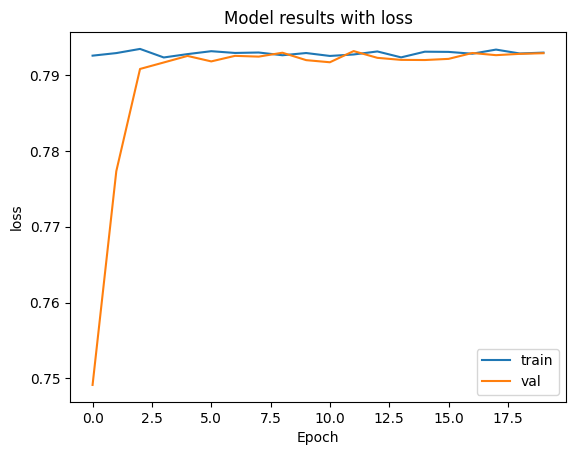

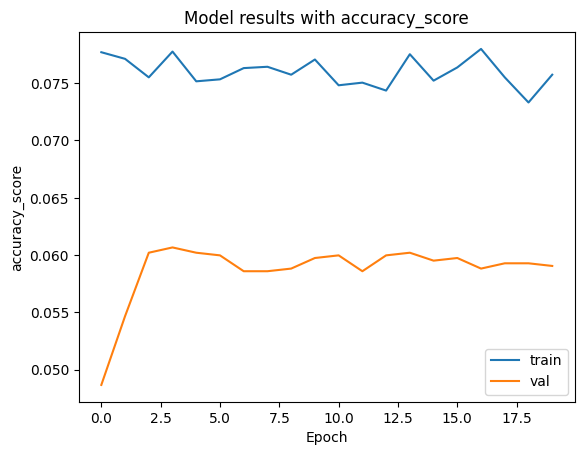

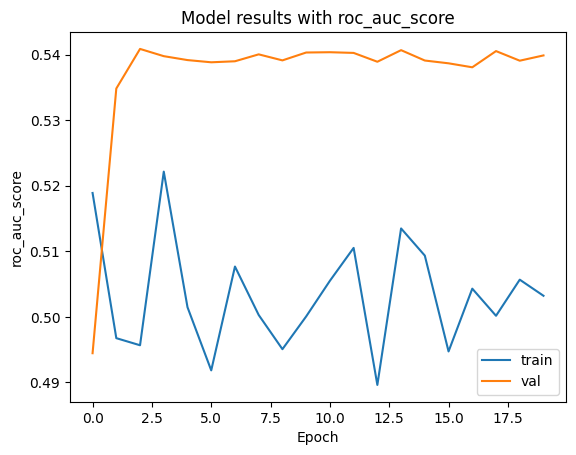

In [85]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()
    plt.show()

plot_metric(history, 'loss')

plot_metric(history, 'accuracy_score')
plot_metric(history, 'roc_auc_score')
   

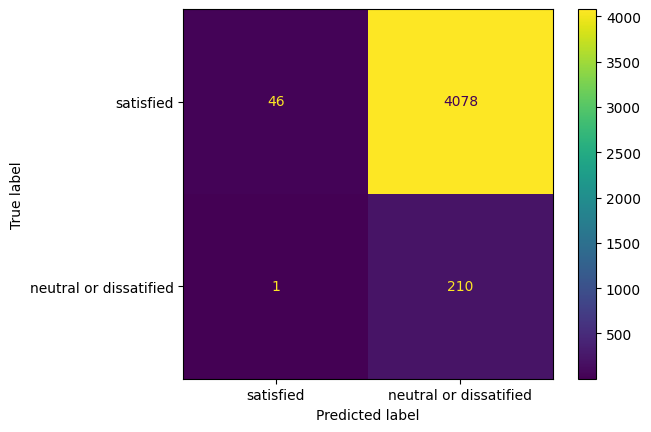

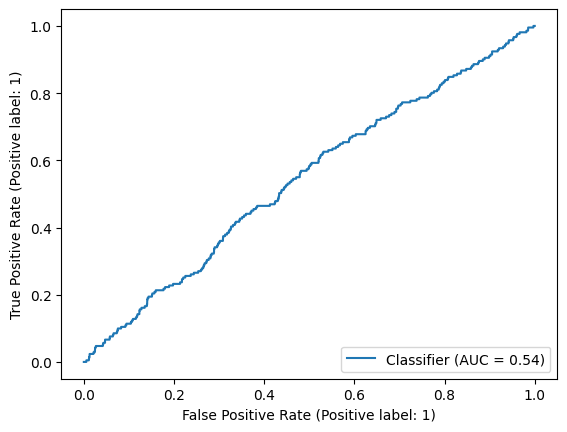

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

model = model.to('cpu')
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.round(),
                                       display_labels=['satisfied', 'neutral or dissatified'])

plt.plot()
RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=1)